In [1]:
%matplotlib inline

In [2]:
XFER_TYPE_MAPPING = {
        0: "Storage-GPU (GDS)",
        1: "Storage-CPU",
        2: "Storage-CPU-GPU",
#         3: "Storage-CPU-GPU_ASYNC",
#         4: "Storage->PAGE_CACHE->CPU->GPU",
#         5: "Storage->GPU_ASYNC",
#         6: "Storage->GPU_BATCH" # Experiments failed
    }

In [3]:
OPERATION_TYPE_MAPPING = {
        0: "read",
        1: "write",
        2: "randread",
        3: "randwrite"
    }

In [4]:
xfer_types_to_skip = set(range(7)).difference(XFER_TYPE_MAPPING)
print(xfer_types_to_skip)

{3, 4, 5, 6}


# GPU0 always used for reading/writing the data

In [5]:
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns

In [6]:
params_path_pattern = r"benchmark-(\d+)-(\d+)-(\d+)-([^-]+)-" # "benchmark-$X-$I-$DEVICE-$ENABLE_NVLINK-${SLURM_JOB_ID}"
io_gpu_pattern = "GPU : (\d) pool_size_MiB : [^\s]+ usage : [^\s]+ used_MiB : [^\s]+"

In [7]:
DATA_DIR = "benchmark-nvlink"

In [8]:
io_gpus = []

pathlist = Path(DATA_DIR).glob('benchmark-*')

for path in pathlist:
    with open(path / "gds_stats.out", "r") as f:
        content = f.read()
        
    gpu_matches = re.findall(io_gpu_pattern, content)
    params_match = re.search(params_path_pattern, str(path))
    
    if int(params_match.group(1)) in {0, 5}:
        for gpu_match in gpu_matches[1:-1]:
            io_gpus.append(gpu_match)

In [9]:
all(x == '0' for x in io_gpus)

True

# Disks throughput

In [10]:
def parse_xfer_type(type_):
    return XFER_TYPE_MAPPING[int(type_)]

In [11]:
def parse_operation_type(type_):
    return OPERATION_TYPE_MAPPING[int(type_)]

In [12]:
io_metrics_names = "r/s     rMB/s   rrqm/s  %rrqm r_await rareq-sz     w/s     wMB/s   wrqm/s  %wrqm w_await wareq-sz     d/s     dMB/s   drqm/s  %drqm d_await dareq-sz  aqu-sz  %util".split()

In [33]:
single_metrics_pattern = r"\s+([^\s]+)"
disk_usage_pattern = r"\n([^\s]+)" + "".join(single_metrics_pattern for _ in range(len(io_metrics_names)))
params_path_pattern = r"benchmark-(\d+)-(\d+)-(\d+)-([^-]+)-" # "benchmark-$X-$I-$DEVICE-$ENABLE_NVLINK-${SLURM_JOB_ID}"

In [34]:
def try_parse_number(str_value):
    try:
        return int(str_value)
    except ValueError:
        pass
    try:
        return float(str_value)
    except ValueError:
        pass
    return str_value

In [35]:
iostat_measurements = []

pathlist = Path(DATA_DIR).glob('benchmark-*')

for path in pathlist:
    with open(path / "iostat.out", "r") as f:
        content = f.read()
        
    params_match = re.search(params_path_pattern, str(path))
    
    if int(params_match.group(1)) in xfer_types_to_skip:
        continue
        
    for i, chunk in enumerate(re.findall(
        r"Device            r/s     rMB/s   rrqm/s  %rrqm r_await rareq-sz     w/s     wMB/s   wrqm/s  %wrqm w_await wareq-sz     d/s     dMB/s   drqm/s  %drqm d_await dareq-sz  aqu-sz  %util(?:\r?\n(?!\r?\n).*)*",
        content
    )[2:-1], start=1):
        measurements = re.findall(disk_usage_pattern, chunk)
        for measurement in measurements:

            if measurement[0] in {"md1", "nvme0n1", "nvme3n1", "nvme4n1", "nvme5n1"}:
                
                iostat_measurements.append({
                    "device": int(params_match.group(3)),
                    "xfer_type": parse_xfer_type(params_match.group(1)),
                    "op_type": parse_operation_type(params_match.group(2)),
                    "nvlink": "enabled" if params_match.group(4) == "true" else "disabled",
                    "observation_index": i,
                    **dict(zip(["disk_device"] + io_metrics_names, (try_parse_number(x) for x in measurement)))
                })

iostat_measurements_df = pd.DataFrame(iostat_measurements)

In [36]:
iostat_measurements_df["xfer_type"] = iostat_measurements_df["xfer_type"].astype(
    CategoricalDtype(categories=XFER_TYPE_MAPPING.values(), ordered=True)
)
iostat_measurements_df["op_type"] = iostat_measurements_df["op_type"].astype(
    CategoricalDtype(categories=OPERATION_TYPE_MAPPING.values(), ordered=True)
)
iostat_measurements_df["nvlink"] = iostat_measurements_df["nvlink"].astype(
    CategoricalDtype(categories=["disabled", "enabled"], ordered=True)
)
iostat_measurements_df["disk_device"] = iostat_measurements_df["disk_device"].astype('category')

In [37]:
iostat_measurements_df["read_throughput (GiB/s)"] = iostat_measurements_df["rMB/s"] / 1024
iostat_measurements_df["write_throughput (GiB/s)"] = iostat_measurements_df["wMB/s"] / 1024

In [38]:
iostat_measurements_df

,device,xfer_type,op_type,nvlink,observation_index,disk_device,r/s,rMB/s,rrqm/s,%rrqm,...,d/s,dMB/s,drqm/s,%drqm,d_await,dareq-sz,aqu-sz,%util,read_throughput (GiB/s),write_throughput (GiB/s)
0,6,Storage-GPU (GDS),randwrite,disabled,1,md1,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,5.129404
1,6,Storage-GPU (GDS),randwrite,disabled,1,nvme0n1,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.96,0.000000,1.159805
2,6,Storage-GPU (GDS),randwrite,disabled,1,nvme3n1,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.96,0.000000,1.100488
3,6,Storage-GPU (GDS),randwrite,disabled,1,nvme4n1,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.96,0.000000,1.210742
4,6,Storage-GPU (GDS),randwrite,disabled,1,nvme5n1,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.88,0.000000,1.151426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4105,7,Storage-CPU,randread,enabled,4,md1,198141.4,22232.43,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,21.711357,0.000000
4106,7,Storage-CPU,randread,enabled,4,nvme0n1,48513.2,4997.13,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.00,4.880010,0.000000
4107,7,Storage-CPU,randread,enabled,4,nvme3n1,50414.6,5076.07,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.00,4.957100,0.000000
4108,7,Storage-CPU,randread,enabled,4,nvme4n1,49244.0,4954.41,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.92,4.838291,0.000000


## The following charts are analogous for randread or randwrite and GDS async

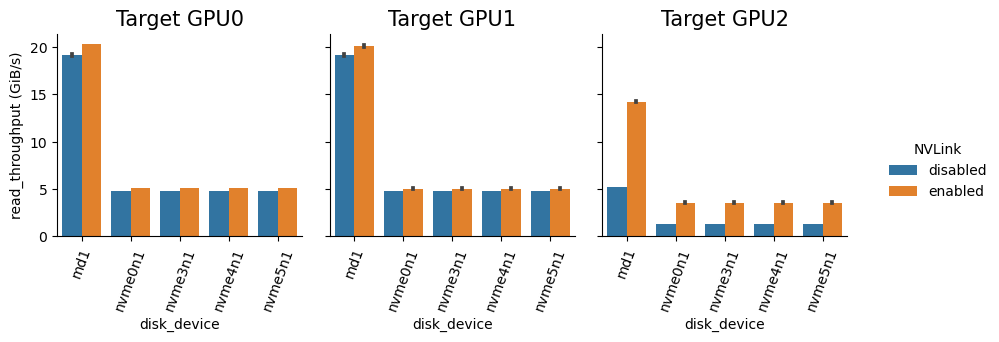

In [39]:
g = sns.FacetGrid(
    iostat_measurements_df[
        (iostat_measurements_df.op_type == "read") & 
        (iostat_measurements_df.xfer_type == "Storage-GPU (GDS)") & 
        (iostat_measurements_df.device <= 2)
    ], col="device", margin_titles=True)
g.set_titles(col_template="Target GPU{col_name}", size=15)
g.map_dataframe(
    sns.barplot, x="disk_device", y="read_throughput (GiB/s)", hue="nvlink", errorbar="se",
    palette=sns.color_palette(n_colors=iostat_measurements_df.disk_device.nunique())
)
g.add_legend(title="NVLink")
# plt.tight_layout()
[plt.setp(ax.get_xticklabels(), rotation=70) for ax in g.axes.flat]
plt.savefig(f"img/{DATA_DIR}/iostat-read-dgx-4-raid-nvlink.pdf", format="pdf")
plt.show()

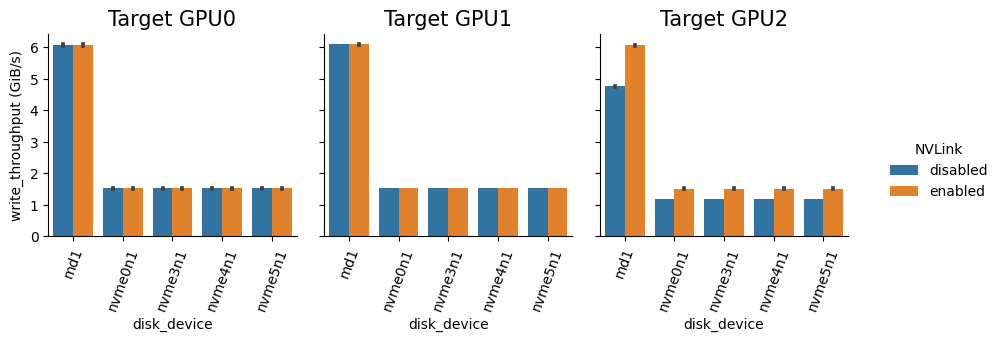

In [40]:
g = sns.FacetGrid(
    iostat_measurements_df[
        (iostat_measurements_df.op_type == "write") &
        (iostat_measurements_df.xfer_type == "Storage-GPU (GDS)") & 
        (iostat_measurements_df.device <= 2)
    ], col="device", margin_titles=True)
g.set_titles(col_template="Target GPU{col_name}", size=15)
g.map_dataframe(
    sns.barplot, x="disk_device", y="write_throughput (GiB/s)", hue="nvlink", errorbar="se",
    palette=sns.color_palette(n_colors=iostat_measurements_df.disk_device.nunique())
)
g.add_legend(title="NVLink")
# plt.tight_layout()
[plt.setp(ax.get_xticklabels(), rotation=70) for ax in g.axes.flat]
plt.savefig(f"img/{DATA_DIR}/iostat-write-dgx-4-raid-nvlink.pdf", format="pdf")
plt.show()

# Throughput and latency

In [21]:
params_pattern = r"/usr/local/cuda/gds/tools/gdsio[^\n]*-d ([^\s]+) -w [^\s]+ -s ([^\s]+) [^\n]*-x ([^\s]+) -I ([^\s]+) -T [^\s]+ (-p)?"
results_pattern = r"Throughput: ([^\s]+) GiB/sec, Avg_Latency: ([^\s]+) usecs"

pathlist = Path(DATA_DIR).glob('slurm-benchmark-*.out')

measurements = []

for path in pathlist:
    with open(path, "r") as f:
        content = f.read()
    params_match = re.search(params_pattern, content)
    results_match = re.search(results_pattern, content)
    if int(params_match.group(3)) in xfer_types_to_skip:
        continue
    measurements.append({
        "device": int(params_match.group(1)),
        "xfer_type": parse_xfer_type(params_match.group(3)),
        "op_type": parse_operation_type(params_match.group(4)),
        "nvlink": "enabled" if params_match.group(5) == "-p" else "disabled",
        "throughput (GiB/sec)": float(results_match.group(1)),
        "latency (usecs)": float(results_match.group(2))
    })

measurements_df = pd.DataFrame(measurements)

In [42]:
measurements_df["xfer_type"] = measurements_df["xfer_type"].astype(
    CategoricalDtype(categories=XFER_TYPE_MAPPING.values(), ordered=True)
)
measurements_df["nvlink"] = measurements_df["nvlink"].astype(
    CategoricalDtype(categories=["disabled", "enabled"], ordered=True)
)
measurements_df["op_type"] = measurements_df["op_type"].astype(
    CategoricalDtype(categories=OPERATION_TYPE_MAPPING.values(), ordered=True)
)

In [43]:
measurements_df

,device,xfer_type,op_type,nvlink,throughput (GiB/sec),latency (usecs)
0,1,Storage-CPU-GPU,write,enabled,10.494709,1487.743582
1,4,Storage-GPU (GDS),read,enabled,14.290126,1091.965845
2,6,Storage-GPU (GDS),read,disabled,5.071973,3063.700798
3,3,Storage-CPU,randread,disabled,19.398168,805.461962
4,4,Storage-GPU (GDS),write,enabled,6.058926,2576.907717
...,...,...,...,...,...,...
187,1,Storage-CPU,randread,disabled,19.443705,803.568406
188,4,Storage-CPU-GPU,randwrite,enabled,10.037064,1555.728647
189,3,Storage-CPU-GPU,read,disabled,9.219512,1693.965604
190,5,Storage-GPU (GDS),randread,disabled,4.953888,3137.044944


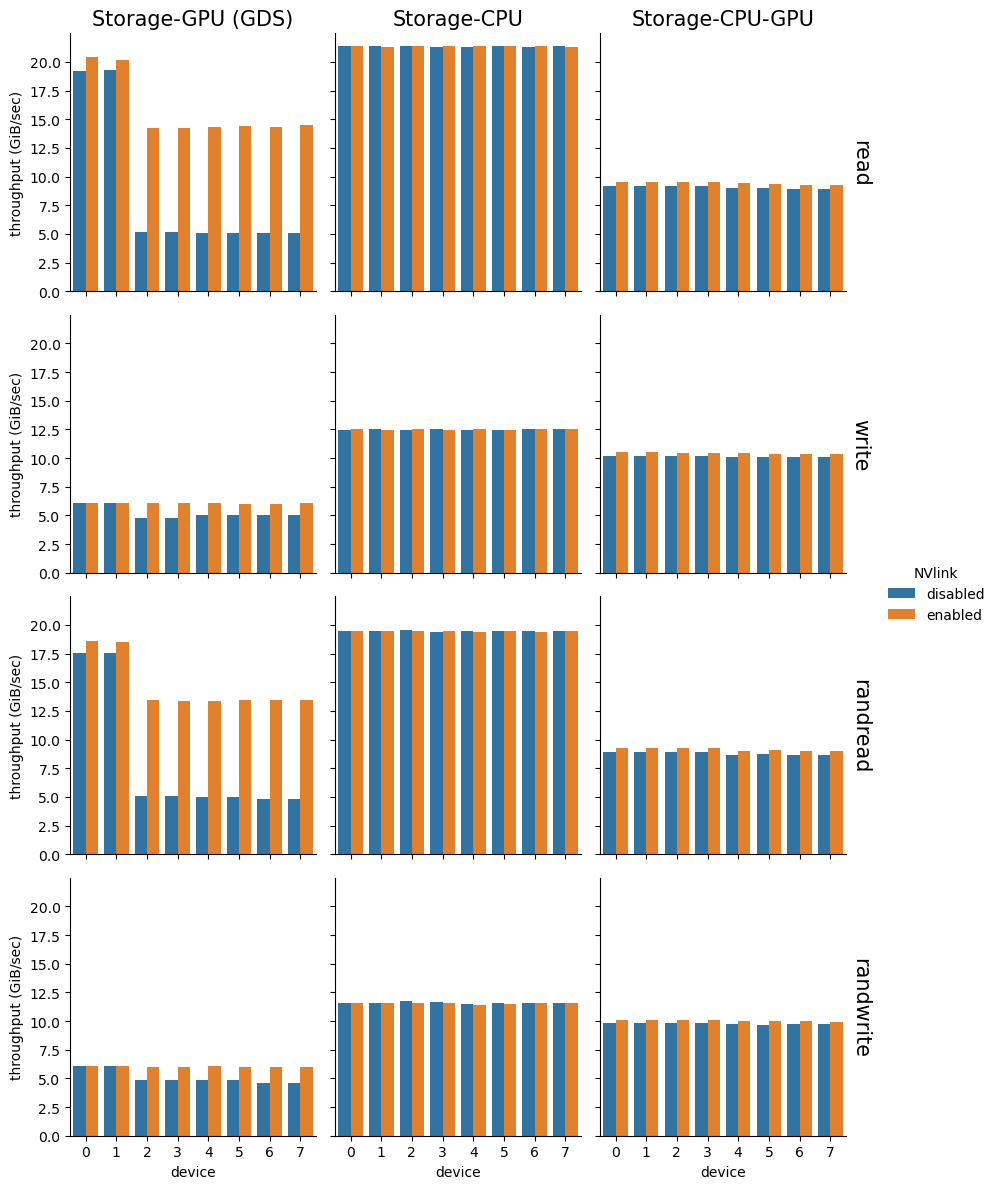

In [44]:
g = sns.FacetGrid(measurements_df, col="xfer_type", row="op_type", margin_titles=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}", size=15)
g.map_dataframe(
    sns.barplot, x="device", y="throughput (GiB/sec)", hue="nvlink",
    palette=sns.color_palette(n_colors=2)
)
g.add_legend(title="NVlink")

plt.savefig(f"img/{DATA_DIR}/throughput-dgx-4-raid-nvlink.pdf", format="pdf")
plt.show()

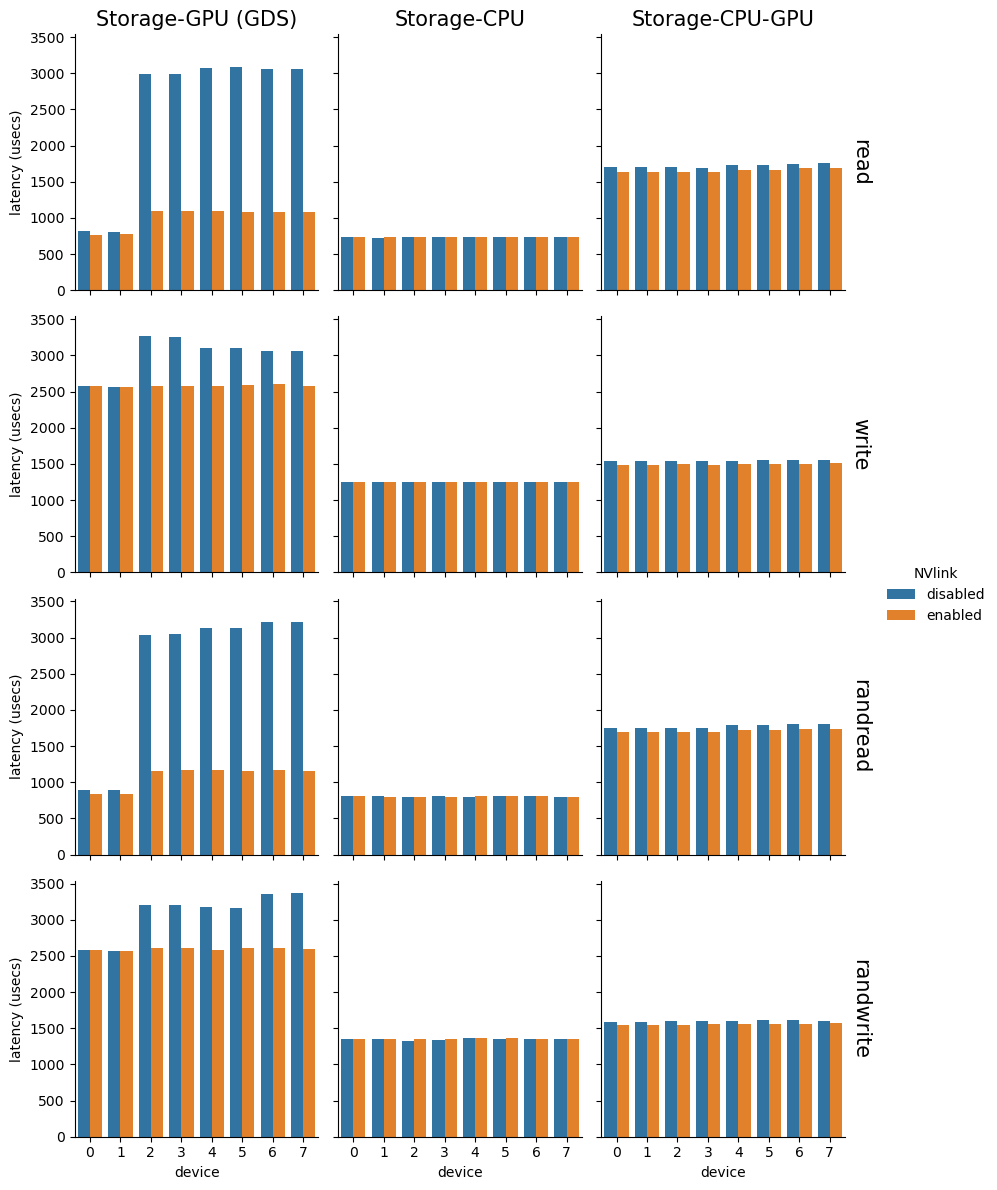

In [45]:
g = sns.FacetGrid(measurements_df, col="xfer_type", row="op_type", margin_titles=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}", size=15)
g.map_dataframe(
    sns.barplot, x="device", y="latency (usecs)", hue="nvlink",
    palette=sns.color_palette(n_colors=2)
)
g.add_legend(title="NVlink")

plt.savefig(f"img/{DATA_DIR}/latency-dgx-4-raid-nvlink.pdf", format="pdf")
plt.show()

# CPU burden

In [26]:
single_metrics_pattern = r"\s*([^\s]+)"
cpu_usage_pattern = rf"avg-cpu:  %user   %nice %system %iowait  %steal   %idle\n{single_metrics_pattern}{single_metrics_pattern}{single_metrics_pattern}{single_metrics_pattern}{single_metrics_pattern}{single_metrics_pattern}"
params_path_pattern = r"benchmark-(\d+)-(\d+)-(\d+)-([^-]+)-" # "benchmark-$X-$I-$DEVICE-$ENABLE_NVLINK-${SLURM_JOB_ID}"

In [27]:
cpu_measurements = []

pathlist = Path(DATA_DIR).glob('benchmark-*')

for path in pathlist:
    with open(path / "iostat.out", "r") as f:
        content = f.read()
        
    cpu_matches = re.findall(cpu_usage_pattern, content)
    params_match = re.search(params_path_pattern, str(path))
    
    if int(params_match.group(1)) in xfer_types_to_skip:
        continue
    
    for i, cpu_match in enumerate(cpu_matches[1:-1], start=1):
        cpu_measurements.append({
            "device": int(params_match.group(3)),
            "xfer_type": parse_xfer_type(params_match.group(1)),
            "op_type": parse_operation_type(params_match.group(2)),
            "nvlink": "enabled" if params_match.group(4) == "true" else "disabled",
            "observation_index": i,
            **dict(zip(["user_cpu", "nice_cpu", "system_cpu", "iowait_cpu", "steal_cpu", "idle_cpu"], cpu_match))
        })

cpu_measurements_df = pd.DataFrame(cpu_measurements)

In [47]:
cpu_measurements_df["xfer_type"] = cpu_measurements_df["xfer_type"].astype(
    CategoricalDtype(categories=XFER_TYPE_MAPPING.values(), ordered=True)
)
cpu_measurements_df["nvlink"] = cpu_measurements_df["nvlink"].astype(
    CategoricalDtype(categories=["disabled", "enabled"], ordered=True)
)
cpu_measurements_df["op_type"] = cpu_measurements_df["op_type"].astype(
    CategoricalDtype(categories=OPERATION_TYPE_MAPPING.values(), ordered=True)
)
for col in cpu_measurements_df.columns:
    if col.endswith("cpu"):
        cpu_measurements_df[col] = cpu_measurements_df[col].astype(float)

In [48]:
cpu_measurements_df

,device,xfer_type,op_type,nvlink,observation_index,user_cpu,nice_cpu,system_cpu,iowait_cpu,steal_cpu,idle_cpu
0,6,Storage-GPU (GDS),randwrite,disabled,1,0.53,0.0,0.54,0.00,0.0,98.93
1,6,Storage-GPU (GDS),randwrite,disabled,2,1.34,0.0,0.30,0.00,0.0,98.37
2,6,Storage-GPU (GDS),randwrite,disabled,3,0.61,0.0,0.23,0.00,0.0,99.16
3,6,Storage-GPU (GDS),randwrite,disabled,4,0.60,0.0,0.22,0.00,0.0,99.18
4,6,Storage-GPU (GDS),randwrite,disabled,5,0.70,0.0,0.20,0.00,0.0,99.10
...,...,...,...,...,...,...,...,...,...,...,...
1009,7,Storage-CPU,randread,enabled,1,0.16,0.0,0.97,0.01,0.0,98.86
1010,7,Storage-CPU,randread,enabled,2,0.02,0.0,0.78,0.00,0.0,99.20
1011,7,Storage-CPU,randread,enabled,3,0.01,0.0,0.79,0.00,0.0,99.19
1012,7,Storage-CPU,randread,enabled,4,0.15,0.0,0.85,0.00,0.0,99.00


In [49]:
cpu_measurements_df.groupby(["xfer_type", "op_type", "device", "nvlink"]).count().min()

observation_index    5
user_cpu             5
nice_cpu             5
system_cpu           5
iowait_cpu           5
steal_cpu            5
idle_cpu             5
dtype: int64

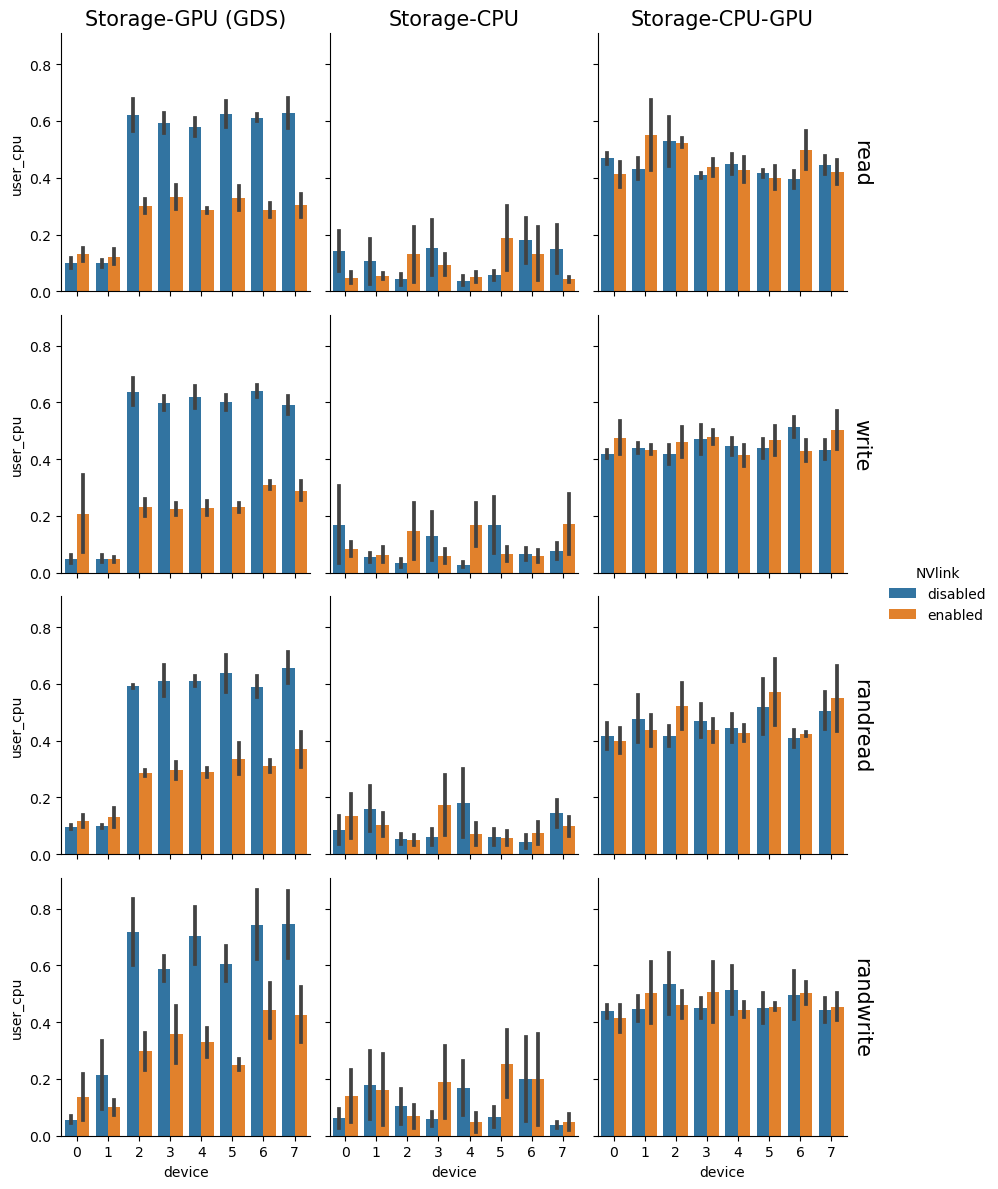

In [50]:
g = sns.FacetGrid(cpu_measurements_df, col="xfer_type", row="op_type", margin_titles=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}", size=15)
g.map_dataframe(
    sns.barplot, x="device", y="user_cpu", hue="nvlink", errorbar="se",
    palette=sns.color_palette(n_colors=2)
)
g.add_legend(title="NVlink")

plt.savefig(f"img/{DATA_DIR}/cpu-user-dgx-4-raid-nvlink.pdf", format="pdf")
plt.show()

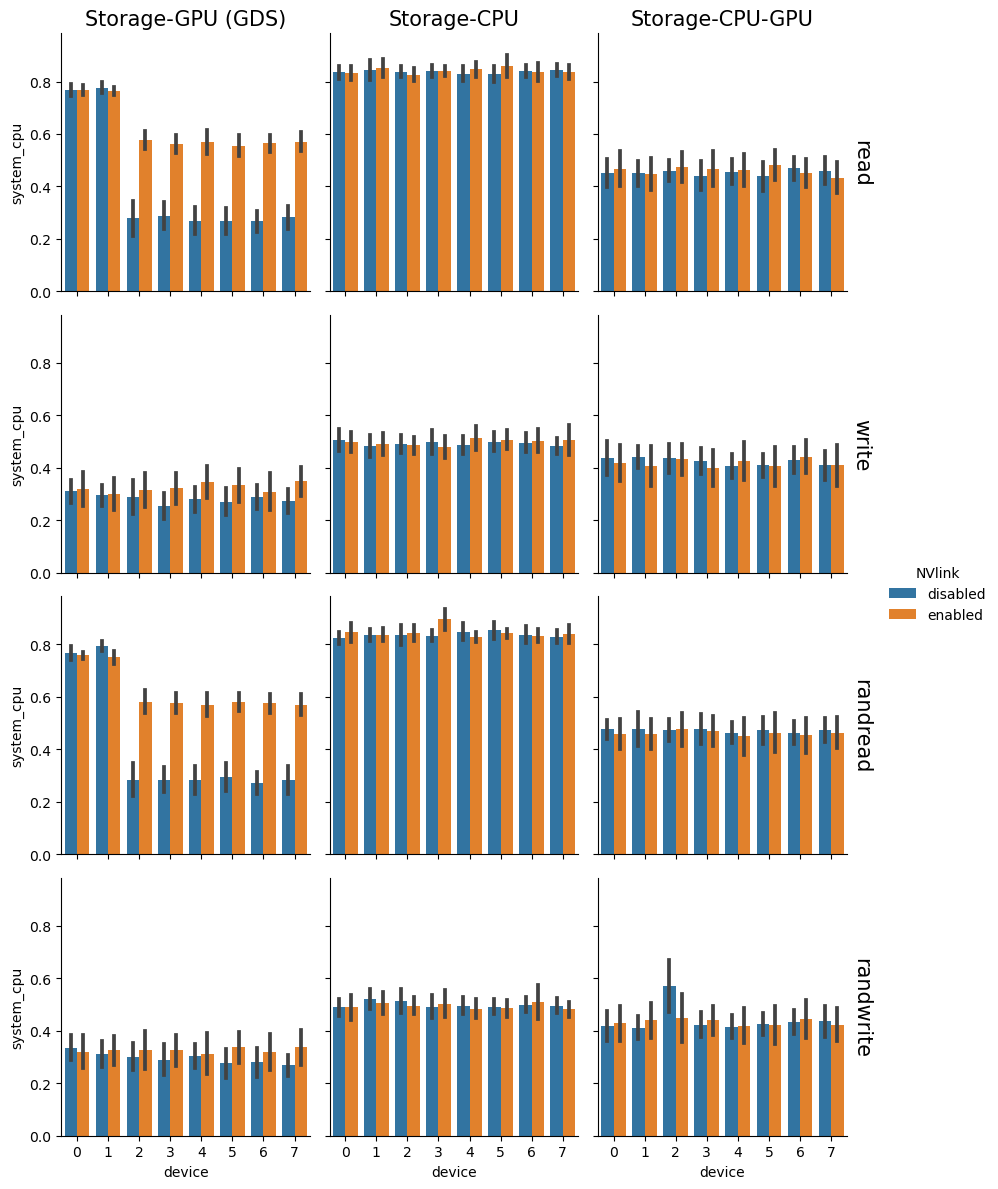

In [51]:
g = sns.FacetGrid(cpu_measurements_df, col="xfer_type", row="op_type", margin_titles=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}", size=15)
g.map_dataframe(
    sns.barplot, x="device", y="system_cpu", hue="nvlink", errorbar="se",
    palette=sns.color_palette(n_colors=2)
)
g.add_legend(title="NVlink")

plt.savefig(f"img/{DATA_DIR}/cpu-system-dgx-4-raid-nvlink.pdf", format="pdf")
plt.show()